In [73]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import seaborn as sns
import copy
from tqdm.notebook import tqdm
from itertools import combinations
import sys
import random
%matplotlib inline

#### Данные:

* Neutral Network

In [2]:
NN = nx.read_edgelist('../data/ca-netscience.txt')
print(round(nx.degree_assortativity_coefficient(NN), 4))

-0.0817


* Assortative Network

In [3]:
AS = nx.read_edgelist('../data/proteins.txt') 
print(round(nx.degree_assortativity_coefficient(AS), 4))

0.3968


* Disassortative Network

In [4]:
DS = nx.read_edgelist('../data/bio-yeast.txt') 
print(round(nx.degree_assortativity_coefficient(DS), 4))

-0.2095


#### 1. Матрица корреляций степеней вершин (3 балла)
* напишите функцию, вычисляющую матрицу корреляции степеней $e_{ij}$;
* напишите функцию, вычисляющую коэффициент ассортативности по матрице корреляций $e_{ij}$:
$$
r=\sum_{jk}\frac{jk\left[e_{jk}-q_jq_k\right]}{\sigma_q^2},
$$
$$
\sigma_q^2=\sum_k k^2q_k-(\sum_k kq_k)^2,
$$
$$
q_j=\sum_{i} e_{ji},
$$

* для заданных сетей постройте матрицы корреляций и вычислите коэффициент ассортативности, сравните со значениями, вычисленными с помощью [функции](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient).

In [5]:
def get_degree_correlation_matrix(G):
    degrees = dict(G.degree())
    max_degree = max(list(degrees.values()))
    E = np.zeros((max_degree + 1,  max_degree + 1))
    for i in G.edges():
        E[degrees[i[0]], degrees[i[1]]] += 1
        E[degrees[i[1]], degrees[i[0]]] += 1
    E /= np.sum(E)
    return E
    
def get_assortativity_from_E(E):
    n = len(E)
    q = np.sum(E, axis=1)
    s = np.sum(np.multiply(np.arange(1, len(q)+1)**2, q)) - np.sum(np.multiply(np.arange(1, len(q)+1), q))**2
    r = 0
    for j in range(n):
        for k in range(n):
            r += j * k * (E[j][k] - q[j] * q[k])
    r /= s
    return r

In [6]:
def compare(G):
    crafted_r = get_assortativity_from_E(get_degree_correlation_matrix(G))
    networkx_r = nx.degree_assortativity_coefficient(G)
    print(f'Crafted method: {crafted_r}\nNX method: { networkx_r}')

In [7]:
compare(NN)

Crafted method: -0.08167784834672827
NX method: -0.08167784834672846


In [8]:
compare(AS)

Crafted method: 0.39677721250363623
NX method: 0.39677721250363557


In [9]:
compare(DS)

Crafted method: -0.20954054116464865
NX method: -0.20954054116464868


In [10]:
def viz_E(E, net_name):
    plt.imshow(E, cmap='PiYG') # для визуализации матрицы корреляций
    plt.title(net_name)
    plt.colorbar()
    plt.show()

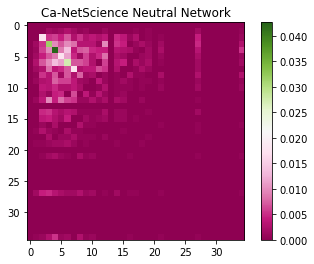

In [11]:
viz_E(get_degree_correlation_matrix(NN), 'Ca-NetScience Neutral Network')

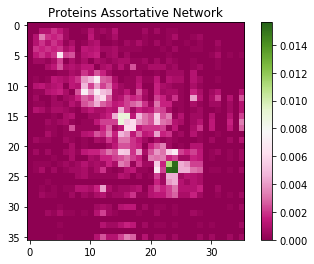

In [12]:
viz_E(get_degree_correlation_matrix(AS), 'Proteins Assortative Network')

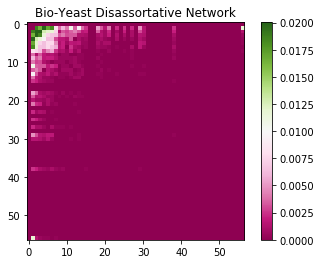

In [13]:
viz_E(get_degree_correlation_matrix(DS), 'Bio-Yeast Disassortative Network')

#### 2. Функция корреляции степеней (3 балла)
* напишите функцию, вычисляющую функцию корреляции $k_{nn}(k)$ для сети:
$$
k_{nn}(k)=\sum_{k'}k'P(k'|k)=\frac{\sum_i{k_{nn,i}}}{N(k)};
$$
$N(k)$ - число вершин степени $k$.
* постройте функции корреляций $k_{nn}(k)$ для заданных сетей. Аппроксимируйте в двойном логарифмическом масштабе полученные зависимости прямой:
$$
\log(k_{nn}(k))=\log(a)+\mu \log k
$$
Чему равны значения $\mu$ для разных сетей? 

In [14]:
def corr(G):
    knni = list(nx.average_neighbor_degree(G).values())
    degrees = dict(G.degree())
    degrees = dict(Counter(sorted(degrees.values())))
    knn = np.zeros(len(degrees.keys()))
    keys = list(degrees.keys())
    for i in range(len(knn)):
        k = degrees[keys[i]]
        knn[i] = np.sum(knni) / k
    return np.array(list(map(int, degrees.keys()))), np.array(knn)

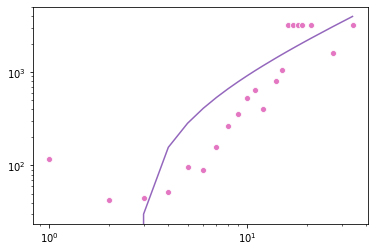

In [15]:
x, y = corr(NN)
sns.scatterplot(x, y, color='tab:pink')
coefs = np.polyfit(x, y, 1)
sns.lineplot(x, coefs[0]*x + coefs[1], color='tab:purple')
plt.yscale("log")
plt.xscale("log")
plt.show()

#### 3. Алгоритм [Xalvi-Brunet & Sokolov](https://en.wikipedia.org/wiki/Xulvi-Brunet%E2%80%93Sokolov_algorithm) (4 балла)
* измените функцию рандомизации сети (предыдущий семинар) так, чтобы рандомизированная сеть была ассортативна/диссортативна ($\rho=1$);

На каждом шаге из вершин $(P,Q), (R,S)$ соединяйте вершины наибольших степеней (ассортативность) или вершину наибольшей степени с вершиной наименьшей степени (диссортативность). Второе ребро соединяет оставшиеся вершины выбранной четверки. 
* проверьте, что алгоритм строит ассортативную/диссортативную сеть на случайных/реальных сетях. 

Исследуйте как влияет ассортативность сети на порог перколяции в случайных графах Эрдеша-Реньи:
* для разных значений $p \in\left[10^{-4},5  \centerdot 10^{-3} \right]$ сгенерируйте ансамбль случайных сетей $G(N,p)$, $N=10^3$, число сетей в ансамбле 10;
* постройте зависимость среднего значения гигантской компоненты в ансамбле как функцию $p$ (см. NS Seminar 03).
* с помощью вашего алгоритма сделайте сети ансамбля ассортативными/диссортативными;
* постройте зависимость среднего значения гигантской компоненты в ансамбле как функцию $p$ для смоделированных сетей (три зависимости на одном графике);

Как изменился порог перколяции? 

In [69]:
def degreesToList(G):
    return [d for n, d in G.degree()]

def step(edges, degrees, p, state):
    nodes = np.ones((4,), dtype=str)
    while any([_[0]==_[1] for _ in combinations(nodes,2)]):
        edges_to_swap = random.choices(edges, k=2)
        nodes = [edges_to_swap[0][0], edges_to_swap[0][1], 
                 edges_to_swap[1][0], edges_to_swap[1][1]]
    
    sdegrees = sorted([(n, degrees[n]) for n in nodes], key=lambda x: x[-1], reverse=False)
    
    if state:
        if np.random.rand() > p:
            edges = (sdegrees[0][0], sdegrees[1][0]), (sdegrees[2][0], sdegrees[3][0])
        else:
            edges = (nodes[0], nodes[-1]), (nodes[2], nodes[1])
    else:
        if np.random.rand() < p:
            edges = (sdegrees[0][0], sdegrees[-1][0]), (sdegrees[1][0], sdegrees[3][0])
        else:
            edges = (nodes[0], nodes[-1]), (nodes[2], nodes[1])
            
    return edges, edges_to_swap

def rewire(G, p, state):
    edges = list(G.edges())
    degrees = dict(G.degree())
    edges_new, edges_old = step(edges, degrees, p, state)
    while any([_ in edges for _ in edges_new]):
        edges_new, edges_old = step(edges, degrees, p, state)
    G.remove_edges_from(edges_old)
    G.add_edges_from(edges_new)

def randomize(G, N_steps, p, state):
    for i in range(N_steps):
        rewire(G, p, state)
    return G
        
def check_degrees(G1: nx.Graph, G2: nx.Graph) -> bool:
    return all(np.array(degreesToList(G1))==np.array(degreesToList(G2)))

In [70]:
def experiment(G):
    N_steps = len(dict(G.edges()))*10
    GA = randomize(copy.deepcopy(G), N_steps, p, True)
    GD = randomize(copy.deepcopy(G), N_steps, p, False)
    
    return len(max(nx.connected_components(G), key=len))/n,\
           len(max(nx.connected_components(GA), key=len))/n,\
           len(max(nx.connected_components(GD), key=len))/n

In [ ]:
res = []
for p in tqdm(np.arange(0.0001, 0.005, 0.0005)):
    n = 1000
    buf = []
    for i in range(10):
        G = nx.erdos_renyi_graph(n, p)    
        buf.append(experiment(G))
        
    res.append(np.mean(np.array(buf), axis=1))

In [ ]:
res = np.array(res)
plt.figure(figsize=(10,5))
plt.plot(np.arange(0.0001, 0.005, 0.0005), res[0, :], label='Normal')
plt.plot(np.arange(0.0001, 0.005, 0.0005), res[1, :], label='Assortative')
plt.plot(np.arange(0.0001, 0.005, 0.0005), res[2, :], label='Disassortative')
plt.legend()
plt.grid()
plt.show()